In [1]:
# basic imports
import os
import json
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_columns', 200)


In [2]:
ROOT = os.getcwd()
RAW = os.path.join(ROOT, "data", "raw")
PROC = os.path.join(ROOT, "data", "processed")
os.makedirs(RAW, exist_ok=True)
os.makedirs(PROC, exist_ok=True)

print("Place aqi.csv in:", RAW)


Place aqi.csv in: C:\Users\Supre\SmogSense\notebooks\data\raw


In [3]:
fn = os.path.join(RAW, "aqi.csv")
assert os.path.exists(fn), f"File not found: {fn} - put your aqi.csv in data/raw/"

df = pd.read_csv(fn)
print("shape:", df.shape)
df.head()


shape: (235785, 9)


date           state      area  number_of_monitoring_stations  \
0  30-04-2025     Maharashtra  Amravati                              2   
1  30-04-2025           Bihar    Purnia                              1   
2  30-04-2025  Madhya Pradesh     Katni                              1   
3  30-04-2025    Chhattisgarh   Tumidih                              1   
4  30-04-2025           Assam  Byrnihat                              1   

  prominent_pollutants  aqi_value air_quality_status  \
0                 PM10         78       Satisfactory   
1                   CO         56       Satisfactory   
2                   O3         98       Satisfactory   
3                 PM10        103           Moderate   
4                PM2.5         61       Satisfactory   

                                                unit  note  
0  number_of_monitoring_stations in Absolute Numb...   NaN  
1  number_of_monitoring_stations in Absolute Numb...   NaN  
2  number_of_monitoring_stations in Absolute Numb...   NaN  
3  number_of_monitoring_stations in Absolute Numb...   NaN  
4  number_of_monitoring_stations in Absolute Numb...   NaN

In [4]:

df.columns = [c.strip().lower().replace(' ', '_').replace('.', '_') for c in df.columns]
print("Columns:", df.columns.tolist())


Columns: ['date', 'state', 'area', 'number_of_monitoring_stations', 'prominent_pollutants', 'aqi_value', 'air_quality_status', 'unit', 'note']


In [5]:
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y', errors='coerce')


print("Missing dates:", df['date'].isna().sum())


df = df.dropna(subset=['date', 'aqi_value']).copy()
df = df.sort_values('date').reset_index(drop=True)


df['aqi_value'] = pd.to_numeric(df['aqi_value'], errors='coerce')
df['number_of_monitoring_stations'] = pd.to_numeric(df['number_of_monitoring_stations'], errors='coerce')

print(df.info())


Missing dates: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235785 entries, 0 to 235784
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   date                           235785 non-null  datetime64[ns]
 1   state                          235785 non-null  object        
 2   area                           235785 non-null  object        
 3   number_of_monitoring_stations  235785 non-null  int64         
 4   prominent_pollutants           235785 non-null  object        
 5   aqi_value                      235785 non-null  int64         
 6   air_quality_status             235785 non-null  object        
 7   unit                           235785 non-null  object        
 8   note                           0 non-null       float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 16.2+ MB
None


In [6]:

def categorize_aqi(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 150:
        return 'Unhealthy for Sensitive Groups'
    elif aqi <= 200:
        return 'Unhealthy'
    elif aqi <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

df['label'] = df['aqi_value'].apply(categorize_aqi)


In [7]:

if 'date' not in df.columns:
    raise KeyError("Column 'date' not found in DataFrame")

df['date'] = pd.to_datetime(df['date'], errors='coerce')


df = df.dropna(subset=['date'])


df = df.set_index('date')


df_hourly = df[['number_of_monitoring_stations', 'aqi_value']].resample('h').mean()

df_hourly['hour'] = df_hourly.index.hour

df_hourly = df_hourly.interpolate(method='time', limit_direction='forward')


df_hourly.head()

number_of_monitoring_stations   aqi_value  hour
date                                                                
2022-04-01 00:00:00                       1.953020  146.691275     0
2022-04-01 01:00:00                       1.952511  146.495257     1
2022-04-01 02:00:00                       1.952001  146.299239     2
2022-04-01 03:00:00                       1.951491  146.103221     3
2022-04-01 04:00:00                       1.950982  145.907203     4

In [8]:
def cap_iqr(s, factor=1.5):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    low = q1 - factor * iqr
    high = q3 + factor * iqr
    return s.clip(lower=low, upper=high)

df_hourly['aqi_value'] = cap_iqr(df_hourly['aqi_value'])
df_hourly['number_of_monitoring_stations'] = cap_iqr(df_hourly['number_of_monitoring_stations'])

df_hourly.describe().T


count        mean        std        min  \
number_of_monitoring_stations  27001.0    1.870058   0.045234   1.751977   
aqi_value                      27001.0  110.781017  37.014191  47.519481   
hour                           27001.0   11.499574   6.922540   0.000000   

                                     25%         50%         75%         max  
number_of_monitoring_stations   1.840171    1.869183    1.898967    1.987160  
aqi_value                      79.332015  109.422283  138.760636  214.012245  
hour                            5.000000   11.000000   17.000000   23.000000

In [9]:
df_feat = df_hourly.reset_index().rename(columns={'date':'datetime'}) if 'datetime' not in df_hourly.columns else df_hourly.reset_index()

if 'datetime' not in df_feat.columns:
    df_feat = df_feat.rename(columns={'date':'datetime'})

# Datetime features
df_feat['hour'] = df_feat['datetime'].dt.hour
df_feat['dayofweek'] = df_feat['datetime'].dt.dayofweek
df_feat['month'] = df_feat['datetime'].dt.month
df_feat['is_weekend'] = df_feat['dayofweek'].isin([5,6]).astype(int)

# Rolling features (AQI)
for w in [3, 24]:
    df_feat[f'aqi_roll_mean_{w}'] = df_feat['aqi_value'].rolling(window=w, min_periods=1).mean()
    df_feat[f'aqi_roll_std_{w}']  = df_feat['aqi_value'].rolling(window=w, min_periods=1).std().fillna(0)

# Lag features
df_feat['aqi_lag_1'] = df_feat['aqi_value'].shift(1)
df_feat['aqi_lag_24'] = df_feat['aqi_value'].shift(24)

# Station lags
df_feat['stations_lag_1'] = df_feat['number_of_monitoring_stations'].shift(1)
df_feat['stations_lag_24'] = df_feat['number_of_monitoring_stations'].shift(24)


df_feat = df_feat.dropna().reset_index(drop=True)

print("Feature columns:", df_feat.columns.tolist())
df_feat.head()


Feature columns: ['datetime', 'number_of_monitoring_stations', 'aqi_value', 'hour', 'dayofweek', 'month', 'is_weekend', 'aqi_roll_mean_3', 'aqi_roll_std_3', 'aqi_roll_mean_24', 'aqi_roll_std_24', 'aqi_lag_1', 'aqi_lag_24', 'stations_lag_1', 'stations_lag_24']


datetime  number_of_monitoring_stations   aqi_value  hour  \
0 2022-04-02 00:00:00                       1.940789  141.986842     0   
1 2022-04-02 01:00:00                       1.939901  141.789683     1   
2 2022-04-02 02:00:00                       1.939012  141.592525     2   
3 2022-04-02 03:00:00                       1.938124  141.395366     3   
4 2022-04-02 04:00:00                       1.937235  141.198207     4   

   dayofweek  month  is_weekend  aqi_roll_mean_3  aqi_roll_std_3  \
0          5      4           1       142.182860        0.196018   
1          5      4           1       141.986462        0.196589   
2          5      4           1       141.789683        0.197159   
3          5      4           1       141.592525        0.197159   
4          5      4           1       141.395366        0.197159   

   aqi_roll_mean_24  aqi_roll_std_24   aqi_lag_1  aqi_lag_24  stations_lag_1  \
0        144.241050         1.386057  142.182860  146.691275        1.941299   
1        144.044984         1.386138  141.986842  146.495257        1.940789   
2        143.848871         1.386292  141.789683  146.299239        1.939901   
3        143.652710         1.386513  141.592525  146.103221        1.939012   
4        143.456502         1.386794  141.395366  145.907203        1.938124   

   stations_lag_24  
0         1.953020  
1         1.952511  
2         1.952001  
3         1.951491  
4         1.950982

In [10]:

raw = pd.read_csv(fn)
raw['date'] = pd.to_datetime(raw['date'],format='%d-%m-%Y',  errors='coerce')
raw = raw.dropna(subset=['date'])
raw = raw.assign(hour = raw['date'].dt.floor('h'))

pollutant_per_hour = raw.groupby(raw['hour'].dt.floor('h'))['prominent_pollutants'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)



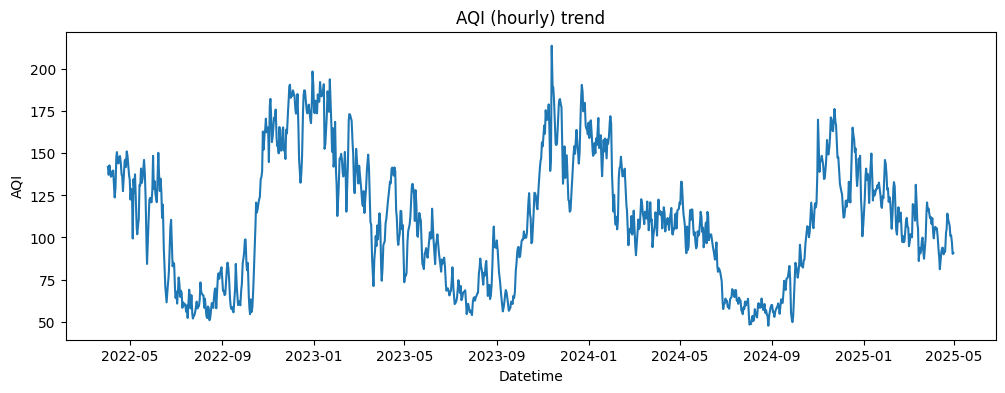

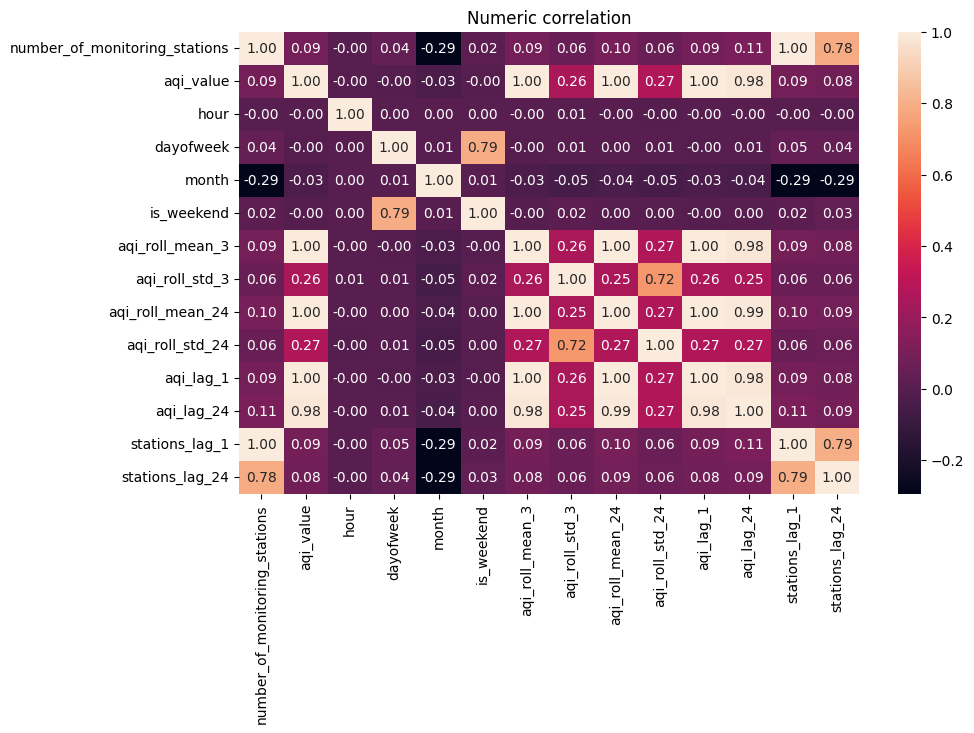

In [11]:
plt.figure(figsize=(12,4))
plt.plot(df_feat['datetime'], df_feat['aqi_value'])
plt.title("AQI (hourly) trend")
plt.xlabel("Datetime")
plt.ylabel("AQI")
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df_feat.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f")
plt.title("Numeric correlation")
plt.show()


In [12]:

drop_cols = ['datetime']  # plus 'note' if present
target = 'aqi_value'

for c in ['note','unit']:
    if c in df_feat.columns:
        drop_cols.append(c)

X = df_feat.drop(columns = drop_cols + [target], errors='ignore')
y = df_feat[target].copy()

print("X shape:", X.shape, "y shape:", y.shape)
X.head()


X shape: (26977, 13) y shape: (26977,)


number_of_monitoring_stations  hour  dayofweek  month  is_weekend  \
0                       1.940789     0          5      4           1   
1                       1.939901     1          5      4           1   
2                       1.939012     2          5      4           1   
3                       1.938124     3          5      4           1   
4                       1.937235     4          5      4           1   

   aqi_roll_mean_3  aqi_roll_std_3  aqi_roll_mean_24  aqi_roll_std_24  \
0       142.182860        0.196018        144.241050         1.386057   
1       141.986462        0.196589        144.044984         1.386138   
2       141.789683        0.197159        143.848871         1.386292   
3       141.592525        0.197159        143.652710         1.386513   
4       141.395366        0.197159        143.456502         1.386794   

    aqi_lag_1  aqi_lag_24  stations_lag_1  stations_lag_24  
0  142.182860  146.691275        1.941299         1.953020  
1  141.986842  146.495257        1.940789         1.952511  
2  141.789683  146.299239        1.939901         1.952001  
3  141.592525  146.103221        1.939012         1.951491  
4  141.395366  145.907203        1.938124         1.950982

In [13]:

split_idx = int(len(X) * 0.8)
X_train = X.iloc[:split_idx].copy()
X_test  = X.iloc[split_idx:].copy()
y_train = y.iloc[:split_idx].copy()
y_test  = y.iloc[split_idx:].copy()

print("Train rows:", X_train.shape[0], "Test rows:", X_test.shape[0])


df_feat.to_csv(os.path.join(PROC, "aqi_preprocessed.csv"), index=False)
X_train.to_csv(os.path.join(PROC, "X_train.csv"), index=False)
X_test.to_csv(os.path.join(PROC, "X_test.csv"), index=False)
y_train.to_csv(os.path.join(PROC, "y_train.csv"), index=False)
y_test.to_csv(os.path.join(PROC, "y_test.csv"), index=False)

print("Saved processed files to", PROC)


Train rows: 21581 Test rows: 5396
Saved processed files to C:\Users\Supre\SmogSense\notebooks\data\processed


In [14]:

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
], remainder='drop')


preprocessor.fit(X_train)
X_train_prep = preprocessor.transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

# Saving preprocessor
joblib.dump(preprocessor, os.path.join(PROC, "preprocessor.joblib"))
print("Saved preprocessor.joblib")


Numeric: ['number_of_monitoring_stations', 'hour', 'dayofweek', 'month', 'is_weekend', 'aqi_roll_mean_3', 'aqi_roll_std_3', 'aqi_roll_mean_24', 'aqi_roll_std_24', 'aqi_lag_1', 'aqi_lag_24', 'stations_lag_1', 'stations_lag_24']
Categorical: []
Saved preprocessor.joblib
